In [2]:
import re
import time
from urllib.parse import urljoin
from typing import Union

import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.webdriver import WebDriver

In [110]:
df = pd.read_csv("test_dataset.csv")

In [112]:
def reformat(phone_number: object) -> Union[str, None]:
    phone_number = re.sub("[^0-9]", "", str(phone_number))

    if len(phone_number) >= 9 and phone_number[:4] != "044":
        return "380" + phone_number[-9:]

    return None

df["Phone"] = df["Phone"].apply(reformat)
df.dropna(subset=["Phone"], inplace = True)
df["Phone"].astype('int64')
df

,NotebookId,Phone,allowed_communications,manager_name
0,10713220,380509140000,True,Ірина Савенко
1,3991423,380634100000,True,Анастасія Бардакова
2,4696490,380445010000,True,Олексій Воронін
3,4598164,380678140000,True,Алла Массольд
5,13255582,380668110000,True,Алла Массольд
...,...,...,...,...
185,1056204,380675080000,True,Меркель Анна
186,9835662,380993920000,True,Меркель Анна
187,1066133,380930757000,False,E-commerce
188,2449583,380979310000,True,E-commerce


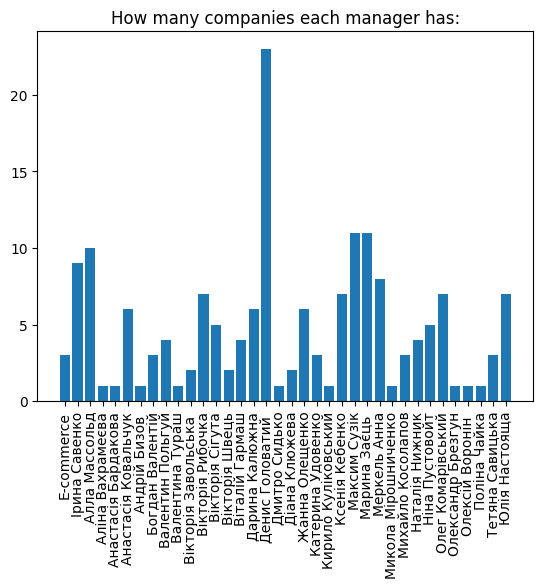

In [113]:
managers_and_companies = df.groupby("manager_name", as_index=False)["NotebookId"].count()

plt.bar(managers_and_companies["manager_name"], managers_and_companies["NotebookId"])
plt.xticks(rotation="vertical")
plt.title("How many companies each manager has:")
plt.show()

In [119]:
df["company_name"] = None
df["number_of_employees"] = None
df["site"] = None
df["is_active"] = None

BASE_URL = "https://rabota.ua/ua"

def parse(company_id: int, driver: WebDriver) -> None:

    driver.get(urljoin(BASE_URL, "company" + str(company_id)))
    time.sleep(1)
    soup = BeautifulSoup(driver.page_source, "html.parser")

    if driver.current_url == "https://rabota.ua/ua/404":
        df.loc[df["NotebookId"] == company_id, "is_active"] = False
        return

    df.loc[df["NotebookId"] == company_id, "is_active"] = True

    if soup.select_one(".santa-typo-h0"):
        name = soup.select_one(".santa-typo-h0").text
        if name.split()[-1] == "Перевірена":
            df.loc[df["NotebookId"] == company_id, "company_name"] = " ".join(name.split()[:-1])
        else:
            df.loc[df["NotebookId"] == company_id, "company_name"] = name

    if soup.select("span.santa-typo-secondary"):
        employees = soup.select("span.santa-typo-secondary")
        if len(employees) > 1:
            employees = soup.select("span.santa-typo-secondary")[1].text
        else:
            employees = soup.select("span.santa-typo-secondary")[0].text
        for i in employees.split():
            if i.isdigit():
                df.loc[df["NotebookId"] == company_id, "number_of_employees"] = int(i)

    if soup.select_one(".santa--my-10"):
        df.loc[df["NotebookId"] == company_id, "site"] = soup.select_one(".santa--my-10")["href"]

options = Options()
options.add_argument("-lang=uk")
options.add_argument("--headless")

with webdriver.Chrome(options=options) as my_driver:
    for id in df["NotebookId"]:
        parse(company_id=id, driver=my_driver)

df.to_csv("cleaned_dataset.csv", index=False)
df

,NotebookId,Phone,allowed_communications,manager_name,company_name,number_of_employees,site,is_active
0,10713220,380509140000,True,Ірина Савенко,Fine Art Shippers,20,https://fineartshippers.com/,True
1,3991423,380634100000,True,Анастасія Бардакова,Synergy group,500,http://synergyodessa.com/,True
2,4696490,380445010000,True,Олексій Воронін,PowerExpert,20,https://powerexpert.ua/,True
3,4598164,380678140000,True,Алла Массольд,"Visak, Отель",100,http://visak-hotel.com.ua/ru/,True
5,13255582,380668110000,True,Алла Массольд,"Нечволод С.О., ФОП",None,https://metaltreat.prom.ua/,True
...,...,...,...,...,...,...,...,...
185,1056204,380675080000,True,Меркель Анна,"ЛБ Ритейл, ТОВ",100,http://www.samsonite.ua/,True
186,9835662,380993920000,True,Меркель Анна,Благий і компанія,20,https://blagyi.com.ua/,True
187,1066133,380930757000,False,E-commerce,Service OnLine Technology,100,http://www.serviceonlinetech.com/,True
188,2449583,380979310000,True,E-commerce,"Транс Кеа Логистик, ООО",20,None,True


In [4]:
new_df = pd.read_csv("cleaned_dataset.csv")
new_df

,NotebookId,Phone,allowed_communications,manager_name,company_name,number_of_employees,site,is_active
0,10713220,380509140000,True,Ірина Савенко,Fine Art Shippers,20.0,https://fineartshippers.com/,True
1,3991423,380634100000,True,Анастасія Бардакова,Synergy group,500.0,http://synergyodessa.com/,True
2,4696490,380445010000,True,Олексій Воронін,PowerExpert,20.0,https://powerexpert.ua/,True
3,4598164,380678140000,True,Алла Массольд,"Visak, Отель",100.0,http://visak-hotel.com.ua/ru/,True
4,13255582,380668110000,True,Алла Массольд,"Нечволод С.О., ФОП",NaN,https://metaltreat.prom.ua/,True
...,...,...,...,...,...,...,...,...
166,1056204,380675080000,True,Меркель Анна,"ЛБ Ритейл, ТОВ",100.0,http://www.samsonite.ua/,True
167,9835662,380993920000,True,Меркель Анна,Благий і компанія,20.0,https://blagyi.com.ua/,True
168,1066133,380930757000,False,E-commerce,Service OnLine Technology,100.0,http://www.serviceonlinetech.com/,True
169,2449583,380979310000,True,E-commerce,"Транс Кеа Логистик, ООО",20.0,NaN,True
